# Exploratory Analysis of Enron Emails

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#textAnalysis">Topic Modeling</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## Introduction

Enron Corporation was an American energy and services company. Enron was a major electricity, natural gas, communications, and pulp and paper company. The Enron Corpus is a database of over 600,000 emails generated by 158 employees of the Enron Corporation in the years leading up to the company's collapse in December 2001 (From Wikipedia). The dataset used for this study is a subset of Enron emails. It only contains 1000 records and 6 columns. How the data was selected or sampled is unknown.
In this study, I performed three main steps:
1. Data Cleaning
2. Exploratory Data Analysis
3. Topic Modeling

The findings may or may not represent the whole Enron emails due to unknown data sampling strategy.

In [1]:
# Load in packages

# Packages for data processing
import numpy as np
import pandas as pd

In [2]:
# NLP packages
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

In [3]:
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyLDAvis
import pyLDAvis.gensim_models

<a id='wrangling'></a>
## Data Cleaning

### Check General Properties

In [4]:
# Read and Check the Data
df = pd.read_csv("../data/enron_test.csv")
df.head()

,Date,From,To,Subject,content,new_date
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n,2001-05-14 23:39:00
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!,2000-10-18 10:00:00
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00


In [5]:
# Check the size of data
df.shape

(1000, 6)

In [6]:
# Check the general info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1000 non-null   object
 1   From      1000 non-null   object
 2   To        995 non-null    object
 3   Subject   698 non-null    object
 4   content   1000 non-null   object
 5   new_date  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [7]:
# Make the column names in one format
df.columns = ['Date', 'From', 'To', 'Subject', 'Content', 'New_date']

In [8]:
# Check whether the dataset contains duplicates
df.duplicated().sum()

336

In [9]:
# Convert values in From, To, Subject and Content columns to lower case before removing duplications.
df.From = df.From.str.lower()
df.To = df.To.str.lower()
df.Subject = df.Subject.str.lower()
df.Content = df.Content.str.lower()

In [10]:
# Check whether the dataset contains duplicates
df.duplicated().sum()

336

In [11]:
# remove duplicates
df = df.drop_duplicates()

In [12]:
# Get the size of df after dedup
df.shape

(664, 6)

In [13]:
# Check some stats of each column
df.describe()

,Date,From,To,Subject,Content,New_date
count,664,664,660,469,664,664
unique,650,41,229,333,657,650
top,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'jsmith@austintx.com'}),re:,i still use this service,1980-01-01 00:00:00
freq,5,610,41,38,2,5


<a id='eda'></a>
## Exploratory Data Analysis

### Univariate Analysis

In [14]:
# Get time zone from Date column 
df['time_zone'] = df['Date'].str.split('(', n = 1, expand = True)[1]
df['time_zone'] = df['time_zone'].str.slice(start=0, stop=3)

In [15]:
# almost evenly sampled between pacific standard time and pacific daylight time.
df['time_zone'].value_counts()

PST    343
PDT    321
Name: time_zone, dtype: int64

In [16]:
# Check email counts over different years
df["Date_year"] = df['Date'].str.split(' ', n=6, expand= True)[3].astype('int')
df["Date_year"].value_counts()

2000    363
2001    294
1979      5
1999      2
Name: Date_year, dtype: int64

In [17]:
# Check email counts over different months
df['Date_month']= df['Date'].str.split(' ', n=6, expand= True)[2]
df['Date_month'].value_counts()

Apr    96
Mar    96
Feb    83
Dec    72
Jan    64
Aug    53
May    52
Sep    42
Oct    35
Jul    30
Nov    22
Jun    19
Name: Date_month, dtype: int64

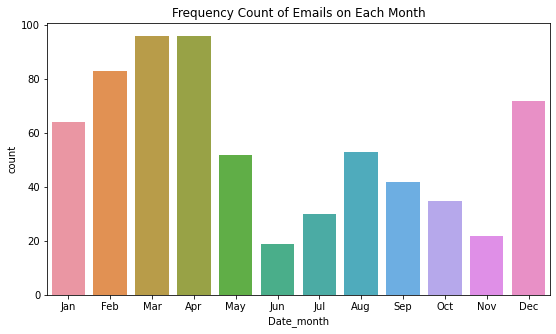

In [18]:
# Plot email counts over different months
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_month", data=df, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep','Oct', 'Nov','Dec'])
plt.title("Frequency Count of Emails on Each Month")
plt.xlabel("Date_month")
plt.show()

In [19]:
# Check email counts over different calendar day
df['Date_day'] = df['Date'].str.split(' ', n=6, expand= True)[1]
df['Date_day'] = df['Date_day'].astype(int)

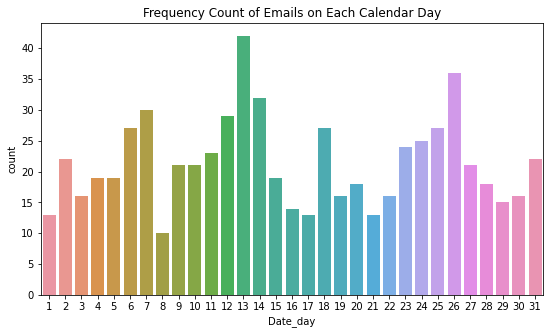

In [20]:
# Plot email counts over different calendar day
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_day", data=df.sort_values("Date_day"))
plt.title("Frequency Count of Emails on Each Calendar Day")
plt.xlabel("Date_day")
plt.show()

In [21]:
# Check email counts over different Weekday
df['Date_weekday'] = df['Date'].str.split(',', n = 1, expand = True)[0]

In [22]:
df['Date_weekday'].value_counts()

Mon    152
Wed    148
Tue    139
Thu    115
Fri     97
Sun      8
Sat      5
Name: Date_weekday, dtype: int64

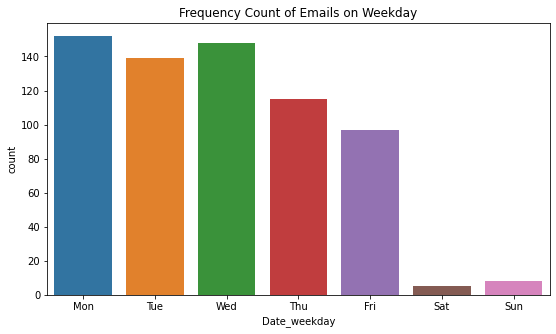

In [23]:
# Plot email counts over different Weekday
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_weekday", data=df, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Frequency Count of Emails on Weekday")
plt.xlabel("Date_weekday")
plt.show()

In [24]:
# Check email counts over different hours in each day
df["Date_hour"] = df['Date'].str.split(' ', n=6, expand= True)[4]\
                            .str.split(':', n=3, expand=True)[0].astype('int')
df["Date_hour"].value_counts()

6     81
7     77
5     72
3     68
4     50
2     46
9     44
1     44
8     42
23    29
0     28
10    16
13    16
16    13
11    11
17     9
12     7
15     4
22     3
18     2
19     1
14     1
Name: Date_hour, dtype: int64

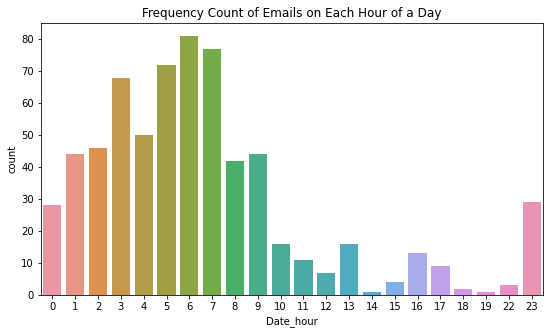

In [25]:
# Plot email counts over different hours in each day
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_hour", data=df.sort_values("Date_hour"))
plt.title("Frequency Count of Emails on Each Hour of a Day")
plt.xlabel("Date_hour")
plt.show()

In [26]:
# Email counts over different hours extracted from column "new_date"
df['New_date_hour'] = df['New_date'].str.split(' ', n=1, expand= True)[1].str.split(':', n = 2, expand=True)[0].astype('int')

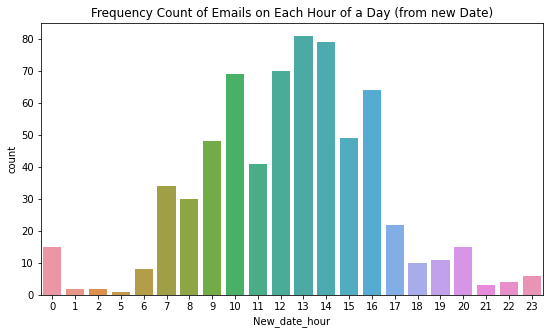

In [27]:
# Plot email counts over different hours in each day (using New_date)
plt.subplots(figsize=(9,5))
sns.countplot(x="New_date_hour", data=df.sort_values("New_date_hour"))
plt.title("Frequency Count of Emails on Each Hour of a Day (from new Date)")
plt.xlabel("New_date_hour")
plt.show()

In [28]:
# Check the sender email boxes
df['From_type'] = df['From'].str.split('@', n=1, expand=True)[1].str.slice(start=0, stop=-3)
df['From_type'].value_counts()

enron.com                    637
ecm.bloomberg.com              2
newsdata.com                   2
austintx.com                   2
earnings.com                   2
inbox.nytimes.com              2
aol.com                        2
ftenergy.com                   2
greenbuilder.com               1
yahoo-inc.com                  1
crest.org                      1
ssm.net                        1
fastpacket.net                 1
freenet.carleton.ca            1
multexinvestornetwork.com      1
intelligencepress.com          1
bga.com                        1
lists.autoweb.com              1
zdemail.zdlists.com            1
listserv.dowjones.com          1
keyad.com                      1
Name: From_type, dtype: int64

In [29]:
# Check who sent the most emails
df['From'].value_counts()

frozenset({'phillip.allen@enron.com'})                    610
frozenset({'critical.notice@enron.com'})                    5
frozenset({'ina.rangel@enron.com'})                         4
frozenset({'sarah.novosel@enron.com'})                      2
frozenset({'messenger@ecm.bloomberg.com'})                  2
frozenset({'aod@newsdata.com'})                             2
frozenset({'ei_editor@ftenergy.com'})                       2
frozenset({'webmaster@earnings.com'})                       2
frozenset({'jsmith@austintx.com'})                          2
frozenset({'announce@inbox.nytimes.com'})                   2
frozenset({'owner-strawbale@crest.org'})                    1
frozenset({'kim.ward@enron.com'})                           1
frozenset({'grensheltr@aol.com'})                           1
frozenset({'yahoo-delivers@yahoo-inc.com'})                 1
frozenset({'perfmgmt@enron.com'})                           1
frozenset({'alyse.herasimchuk@enron.com'})                  1
frozense

In [67]:
# How many unique senders?
df['From'].nunique()

41

In [30]:
# Check which receiver gets most emails
df['To'].value_counts()

frozenset({'jsmith@austintx.com'})                                    41
frozenset({'stagecoachmama@hotmail.com'})                             40
frozenset({'ina.rangel@enron.com'})                                   37
frozenset({'pallen70@hotmail.com'})                                   28
frozenset({'keith.holst@enron.com'})                                  24
                                                                      ..
frozenset({'stephane.brodeur@enron.com'})                              1
frozenset({'brian.hoskins@enron.com'})                                 1
frozenset({'steven.south@enron.com'})                                  1
frozenset({'fletcher.sturm@enron.com'})                                1
frozenset({'barry.tycholiz@enron.com', 'phillip.allen@enron.com'})     1
Name: To, Length: 229, dtype: int64

In [31]:
# From previous step, we see some email have multiple receivers. Check how many emails have multiple receivers. 
# Result about 10%
df['Receiver_num']=df['To'].str.count(',') + 1
df[df['Receiver_num']>1].shape

(63, 15)

In [32]:
# Check which receiver gets most emails
from collections import Counter
dict_receriver_occ = Counter(df['To'].values.tolist())
print(dict_receriver_occ)

Counter({"frozenset({'jsmith@austintx.com'})": 41, "frozenset({'stagecoachmama@hotmail.com'})": 40, "frozenset({'ina.rangel@enron.com'})": 37, "frozenset({'pallen70@hotmail.com'})": 28, "frozenset({'keith.holst@enron.com'})": 24, "frozenset({'cbpres@austin.rr.com'})": 20, "frozenset({'john.lavorato@enron.com'})": 17, "frozenset({'maryrichards7@hotmail.com'})": 16, "frozenset({'jacquestc@aol.com'})": 14, "frozenset({'mike.grigsby@enron.com'})": 13, "frozenset({'llewter@austin.rr.com'})": 10, "frozenset({'rlehmann@yahoo.com'})": 8, "frozenset({'stouchstone@natsource.com'})": 7, "frozenset({'mike.grigsby@enron.com', 'keith.holst@enron.com'})": 7, "frozenset({'pallen@enron.com'})": 7, "frozenset({'mac.d.hargrove@rssmb.com'})": 6, "frozenset({'matthew.lenhart@enron.com'})": 6, "frozenset({'jeff.richter@enron.com'})": 6, "frozenset({'andrea.richards@enron.com'})": 6, "frozenset({'frank.ermis@enron.com', 'mike.grigsby@enron.com', 'keith.holst@enron.com'})": 6, "frozenset({'phillip.allen@enron

In [66]:
# How many unique email addresses in "To"?
len(dict_receriver_occ)

230

In [33]:
df['To_type'] = df['To'].str.split('@', n=1, expand=True)[1].str.slice(start=0, stop=-3)
df[df['Receiver_num']==1]['To_type'].value_counts()

enron.com                324
hotmail.com               88
austintx.com              41
austin.rr.com             30
aol.com                   15
yahoo.com                 12
natsource.com              7
intelligencepress.com      7
keyad.com                  6
rssmb.com                  6
creativepanel.com          4
crest.org                  4
thedoghousemail.com        4
caprock.net                4
ect.enron.com              3
webtv.net                  3
sempratrading.com          2
juno.com                   2
pdq.net                    2
ev1.net                    2
thermon.com                2
spbank.com                 2
spector.ftenergy.com       2
listserv.dowjones.com      1
ren-6.cais.net             1
proxy4.ba.best.com         1
palm.net                   1
mailman.enron.com          1
mh.com                     1
1411west.com               1
living.com                 1
pagenetmessage.net         1
geoswan.com                1
home.com                   1
surffree.com  

### Multivariate Analysis

In [34]:
# Check how emails distributed for years for the dominant sender Phillip Allen. 
df[df['From']== "frozenset({'phillip.allen@enron.com'})"].Date_year.value_counts()

2000    322
2001    281
1979      5
1999      2
Name: Date_year, dtype: int64

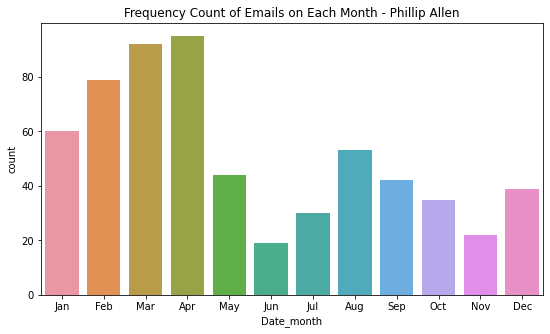

In [35]:
# Check how emails distributed for Months for the dominant sender Phillip Allen. 
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_month", data=df[df['From']== "frozenset({'phillip.allen@enron.com'})"], order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep','Oct', 'Nov','Dec'])
plt.title("Frequency Count of Emails on Each Month - Phillip Allen")
plt.xlabel("Date_month")
plt.show()

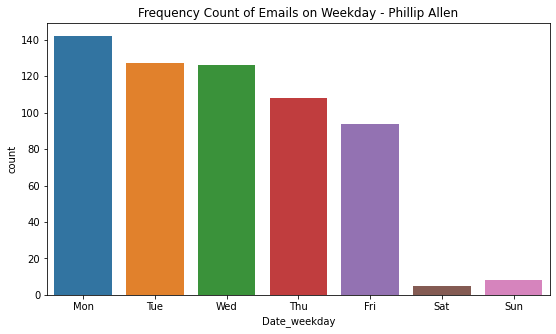

In [36]:
# Check how emails distributed for Weekday for the dominant sender Phillip Allen. 
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_weekday", data=df[df['From']== "frozenset({'phillip.allen@enron.com'})"], order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Frequency Count of Emails on Weekday - Phillip Allen")
plt.xlabel("Date_weekday")
plt.show()

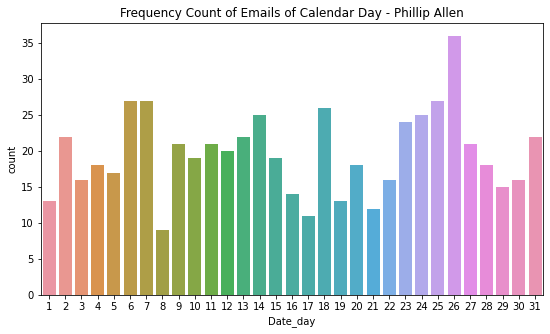

In [37]:
# Check how emails distributed for Calendar day for the dominant sender Phillip Allen. 
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_day", data=df[df['From']== "frozenset({'phillip.allen@enron.com'})"].sort_values("Date_day"))
plt.title("Frequency Count of Emails of Calendar Day - Phillip Allen")
plt.xlabel("Date_day")
plt.show()

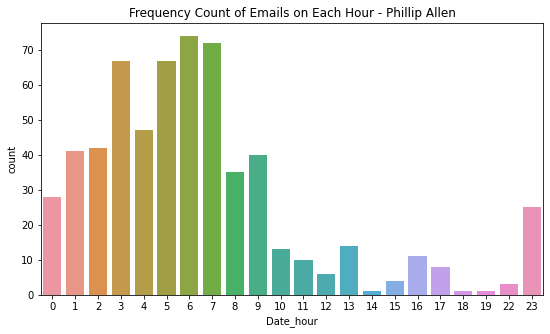

In [38]:
# Check how emails distributed for Hours for the dominant sender Phillip Allen. 
plt.subplots(figsize=(9,5))
sns.countplot(x="Date_hour", data=df[df['From']== "frozenset({'phillip.allen@enron.com'})"].sort_values("Date_hour"))
plt.title("Frequency Count of Emails on Each Hour - Phillip Allen")
plt.xlabel("Date_hour")
plt.show()

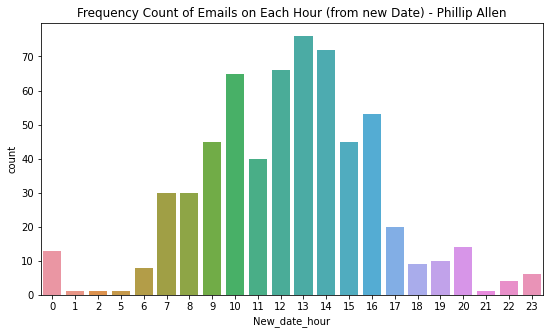

In [39]:
# Check how emails distributed for Hours (from New_Date) for the dominant sender Phillip Allen. 
plt.subplots(figsize=(9,5))
sns.countplot(x="New_date_hour", data=df[df['From']== "frozenset({'phillip.allen@enron.com'})"].sort_values("New_date_hour"))
plt.title("Frequency Count of Emails on Each Hour (from new Date) - Phillip Allen")
plt.xlabel("New_date_hour")
plt.show()

In [40]:
# Check how emails distributed for years for Jsmith who received most emails. 
df[df['To']== "frozenset({'jsmith@austintx.com'})"].Date_year.value_counts()


2001    25
2000    15
1979     1
Name: Date_year, dtype: int64

In [41]:
# Get the year-month combinations
df['New_date_year_month'] = df['New_date'].str.slice(start=0, stop=7)

In [42]:
# A function to plot email counts per year-month for an email address
def plot_emails_per_year_month(email, df, to_or_from):
    year_month_order = df[df[to_or_from]== email].New_date_year_month.unique().tolist()
    year_month_order.sort()
    plt.subplots(figsize=(9,5))
    sns.countplot(y="New_date_year_month", data=df[df[to_or_from]== email], order=year_month_order)
    plt.title("Frequency Count of Emails on Each Month-Year")
    plt.xlabel("New_date_year_month-Year")
    plt.show()

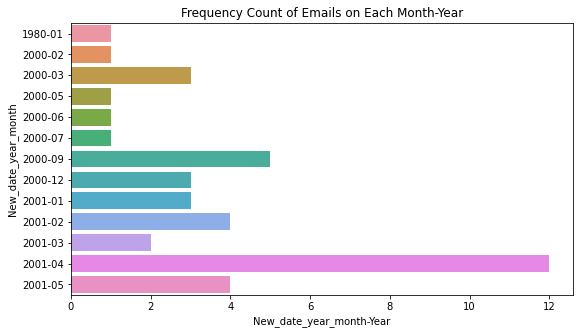

In [43]:
plot_emails_per_year_month("frozenset({'jsmith@austintx.com'})", df, 'To')

In [44]:
# Check how emails distributed for years for stagecoachmama who received second most emails. 
df[df['To']== "frozenset({'stagecoachmama@hotmail.com'})"].Date_year.value_counts()

2000    22
2001    18
Name: Date_year, dtype: int64

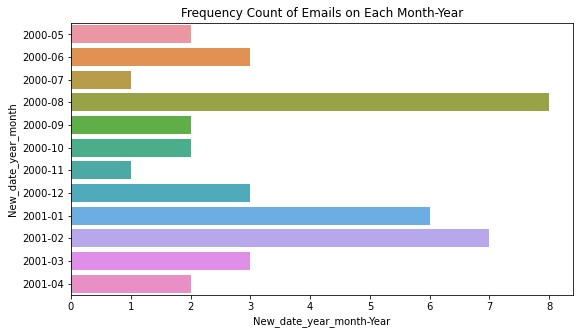

In [45]:
plot_emails_per_year_month("frozenset({'stagecoachmama@hotmail.com'})", df, 'To')

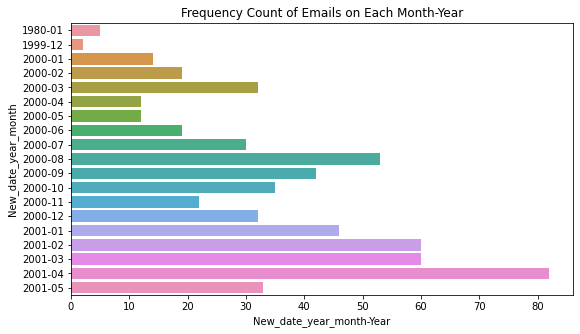

In [46]:
#check Pillip Allen again
plot_emails_per_year_month("frozenset({'phillip.allen@enron.com'})", df, 'From')

<a id='textAnalysis'></a>
## Topic Modeling for Email Content

In [47]:
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
import spacy # spacy for lemmatization

In [48]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm")

In [49]:
# Convert email body to list
data = df.Content.values.tolist()
data[3]

'randy,\n\n can you send me a schedule of the salary and level of everyone in the \nscheduling group.  plus your thoughts on any changes that need to be made.  \n(patti s for example)\n\nphillip'

In [50]:
# tokenize - break down each sentence into a list of words
def sent_to_words(sentences):
    for s in sentences:
        yield(gensim.utils.simple_preprocess(str(s), deacc=True))  # deacc=True removes punctuations

In [51]:
# remove stop_words, make bigrams and lemmatize
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [52]:
data_words = list(sent_to_words(data))

In [53]:
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [54]:
print(trigram_mod[bigram_mod[data_words[50]]])

['forwarded', 'by', 'phillip', 'allen', 'hou', 'ect', 'on', 'am', 'ina_rangel', 'pm', 'to', 'phillip', 'allen', 'hou', 'ect', 'ect', 'cc_subject', 're', 'survey', 'phillip', 'allen', 'full', 'name', 'phillip', 'allen', 'login', 'id', 'pallen', 'extension', 'office', 'location', 'eb', 'what', 'type', 'of', 'computer', 'do', 'you', 'have', 'desktop_laptop_both', 'both', 'do', 'you', 'have', 'pda', 'if', 'yes', 'what', 'type', 'do', 'you', 'have', 'none_ipaq_palm', 'pilot', 'jornada', 'ipaq', 'do', 'you', 'have', 'permission', 'to', 'access', 'anyone', 'email_calendar', 'no', 'if', 'yes_who', 'does', 'anyone', 'have', 'permission', 'to', 'access', 'your', 'email_calendar', 'yes', 'if', 'yes_who', 'ina_rangel', 'are', 'you', 'responsible', 'for', 'updating_anyone_else', 'address_book', 'if', 'yes_who', 'no', 'is', 'anyone_else_responsible', 'for', 'updating', 'your', 'address_book', 'if', 'yes_who', 'no', 'do', 'you', 'have', 'access', 'to', 'shared_calendar', 'if', 'yes', 'which', 'shared

In [55]:
# Define Stop words using NLTK
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [56]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [57]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [58]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [59]:
# create dictionary and corpus both are needed for (LDA) topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [60]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [61]:
print(lda_model.print_topics())# The weights reflect how important a keyword is to that topic.

[(0, '0.203*"free" + 0.083*"http" + 0.042*"chance" + 0.038*"fine" + 0.027*"msn" + 0.023*"happy" + 0.022*"almost" + 0.014*"roll" + 0.014*"stagecoachmama_hotmail" + 0.013*"profile"'), (1, '0.214*"average" + 0.074*"delivery" + 0.000*"weather" + 0.000*"temperature" + 0.000*"degree" + 0.000*"spot" + 0.000*"increase" + 0.000*"decline" + 0.000*"bloomberg_index" + 0.000*"natural_gas"'), (2, '0.089*"project" + 0.034*"position" + 0.033*"grid" + 0.023*"finance" + 0.021*"revise" + 0.021*"building" + 0.018*"mix" + 0.017*"main" + 0.017*"unit" + 0.015*"change"'), (3, '0.059*"thought" + 0.040*"patti" + 0.020*"scheduling" + 0.015*"salary" + 0.000*"award" + 0.000*"frequently" + 0.000*"deserve" + 0.000*"explosion" + 0.000*"extra" + 0.000*"state"'), (4, '0.025*"time" + 0.018*"go" + 0.017*"today" + 0.016*"work" + 0.015*"phillip" + 0.015*"fall" + 0.015*"call" + 0.014*"list" + 0.014*"file" + 0.013*"send"'), (5, '0.089*"music" + 0.084*"net" + 0.037*"split" + 0.032*"rockie" + 0.015*"usually" + 0.003*"clip" + 0

In [62]:
# Model perplexity and topic coherence
# Compute Perplexity - lower value means a better model
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  


Perplexity:  -11.796241511950992


In [63]:
# Compute Coherence Score - 
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4168082743006205


In [64]:
# Visualize the topics
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

/Users/syan/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/syan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syan/opt/anaconda3/lib/python3.9/site-p

In [65]:
pyLDAvis.display(vis)

<a id='conclusions'></a>
## Conclusions
1. The dataset has 664 unique records spreaded for 41 senders, but 610 records are from one sender phillip.allen@enron.com.
2. There are 230 unique receiver email address, and the most frequent receiver jsmith@austintx.com has received 41 emails.
3. Majority of the emails are in the time frame of Jan 2000 to May 2001. Only 2 emails in 1999 and 5 emails in 1979.
4. April 2001 is a very busy month. Phillip Allen has more than 80 emails sent in that month.
5. Using LDA method, topic clusters were determined.
   - Topic 1: the most relevant terms are [time, go, today, work, phillip, fall, call, list, file, send, plan, email, get, questions,...] A number of the key words related with communication.
   - Topic 2 seems to related with energy sales, because the most relevant terms are [price, power, market, buy, say, high, trade, day, demand, year, sell, utility, gas, ...]
   - The top terms [ect, ee, hou] may suggest Topic 3 is about discussions on electricity in Houston, since Enron is based in Texas and provided electricity.
   - Topic 4 has the most relevant terms [phillip, forward, pm, gas, ...]. Since majority of the emails in this dataset were sent by Phillip, his name appears in almost every email. Forward is a common email related term. Phillip's communication itself is a topic.
   - Topic 5 may be related with quoting and payments, because the top terms [cost, loan, cash, land, total, fee, amount, rate] are all about money.
   